In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report

#### Load Datasets  
_Change the value of `ds` to change dataset_

In [2]:
# Change this line to change dataset between (ds = 1) and (ds = 2)
ds = 2

info = pd.read_csv('data/info_{0}.csv'. format(ds), index_col=0)
train_data = pd.read_csv('data/train_{0}.csv'.format(ds), header=None)
val_data = pd.read_csv('data/val_{0}.csv'.format(ds), header=None)
test_data = pd.read_csv('data/test_with_label_{0}.csv'.format(ds), header=None)

model_name = 'Best-DT'
output_csv = "output/{0}-DS{1}.csv".format(model_name, ds)

In [3]:
# Data definitions
X_train = train_data.iloc[:, :-1]
y_train = train_data.iloc[:, -1]
X_val = val_data.iloc[:, :-1]
y_val = val_data.iloc[:, -1]
X_test = test_data.iloc[:, :-1]
y_test = test_data.iloc[:, -1]

#join train and validation sets for grid search
X = pd.concat([X_train, X_val], axis=0)
y = pd.concat([y_train, y_val], axis=0)

#### Predefine split of train and validation set Fit Data

In [4]:
test_fold = np.concatenate([np.repeat(-1, len(X_train.index)), 
                            np.repeat(0, len(X_val.index))], axis = 0)
ps = PredefinedSplit(test_fold=test_fold)

#### Fit Data

In [5]:
DT_model = DecisionTreeClassifier(random_state=42)
parameters = {'criterion':['gini', 'entropy'], 'max_depth':[10, None], 'min_samples_split':[2,3,4,5], 'min_impurity_decrease':[0, 0.001, 0.01, 0.1], 'class_weight': ['balanced', None]}
BestDT_model = GridSearchCV(DT_model, parameters, n_jobs=-1, cv=ps)
BestDT_model.fit(X, y)

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'class_weight': ['balanced', None],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [10, None],
                         'min_impurity_decrease': [0, 0.001, 0.01, 0.1],
                         'min_samples_split': [2, 3, 4, 5]})

In [6]:
print('Best Parameters: {}'.format(BestDT_model.best_params_))
print('Best Score: {}'.format(BestDT_model.best_score_))

Best Parameters: {'class_weight': None, 'criterion': 'entropy', 'max_depth': None, 'min_impurity_decrease': 0.001, 'min_samples_split': 2}
Best Score: 0.7762820512820513


#### Make and Output Prediction

In [7]:
y_pred = pd.Series(BestDT_model.predict(X_test))
y_pred.to_csv(output_csv, header=None)
y_pred

0      9
1      0
2      5
3      5
4      9
      ..
515    0
516    1
517    9
518    6
519    5
Length: 520, dtype: int64

#### Output Confusion Matrix and Plot

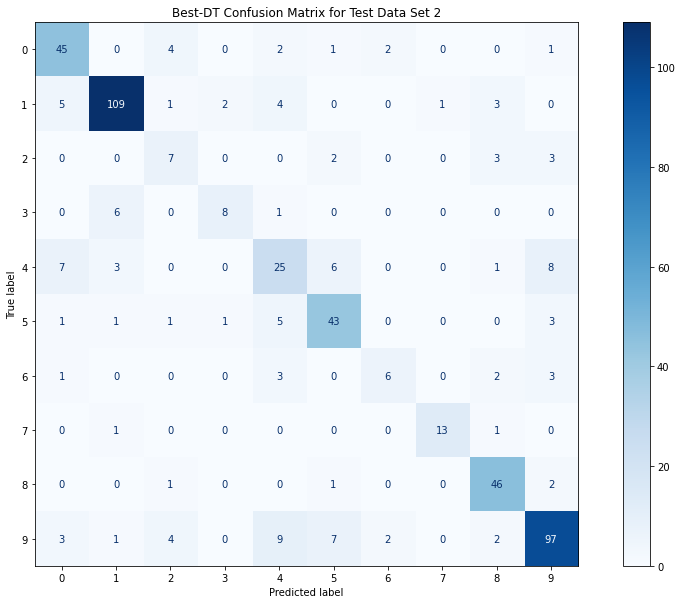

In [8]:
outmatrix = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(16,10))
plot_confusion_matrix(BestDT_model, X_test, y_test, cmap='Blues', ax=ax)
ax.set_title('{0} Confusion Matrix for Test Data Set {1}'.format(model_name, ds))
plt.savefig('img/{0}_confusion_matrix_DS{1}'.format(model_name, ds))
plt.show()

#### Compute Metrics per Class

In [9]:
def compute_metrics(df, y_true, y_pred):
    df_metrics = pd.DataFrame(classification_report(y_true, y_pred, target_names=df['symbol'], output_dict=True, zero_division=0)).T
    df_metrics['symbol'] = df_metrics.index
    df_metrics
    return pd.merge(df, df_metrics, how='right')

info = compute_metrics(info, y_test, y_pred)
info.to_csv(output_csv, mode='a')
info

,symbol,precision,recall,f1-score,support
0,pi,0.725806,0.818182,0.769231,55.000000
1,alpha,0.900826,0.872000,0.886179,125.000000
2,beta,0.388889,0.466667,0.424242,15.000000
3,sigma,0.727273,0.533333,0.615385,15.000000
4,gamma,0.510204,0.500000,0.505051,50.000000
5,delta,0.716667,0.781818,0.747826,55.000000
6,lambda,0.600000,0.400000,0.480000,15.000000
7,omega,0.928571,0.866667,0.896552,15.000000
8,mu,0.793103,0.920000,0.851852,50.000000
9,xi,0.829060,0.776000,0.801653,125.000000


#### Compute Metrics for the Model

In [10]:
def compute_scores(y_test, y_pred):
    return [
        sklearn.metrics.accuracy_score(y_test, y_pred),
        sklearn.metrics.f1_score(y_test, y_pred, average='macro'),
        sklearn.metrics.f1_score(y_test, y_pred, average='weighted')
    ]

model_desc = pd.DataFrame(index=['accuracy', 'macro-average-f1', 'weighted-average-f1'])

model_desc['DS{}'.format(ds)] = compute_scores(y_test, y_pred)
model_desc['DS{}'.format(ds)].to_frame().T.to_csv(output_csv, mode='a')
model_desc

,DS2
accuracy,0.767308
macro-average-f1,0.697797
weighted-average-f1,0.766356
